In [224]:
#imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import time

from scipy.stats import qmc

mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.usetex"] = True

In [144]:
tf.keras.backend.set_floatx("float32")

In [315]:
n_bc = 4
n_data_per_bc = 8

engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc, n_data_per_bc, 3])

In [316]:
for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i,:,0] = j
        data[i,:,1] = points
    else:
        data[i,:,0] = points
        data[i,:,1] = j

In [318]:
data[1,:,2] = 1.
data[2,:,2] = 1.
data[3,:,2] = 1.

In [319]:
data = data.reshape(n_data_per_bc*n_bc, 3)

In [320]:
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

In [321]:
#
N_c = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=N_c)
colloc = 2 * (colloc -0.5)

In [322]:
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

In [323]:
# Transform to float32
x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float32),
                             [x_c, y_c, x_d, y_d, t_d])

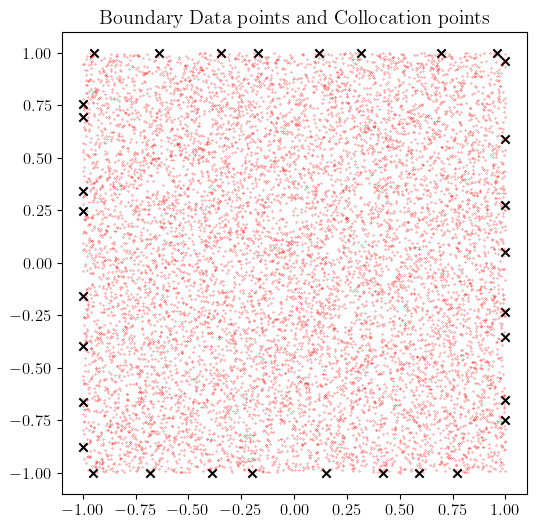

In [324]:
plt.figure("", figsize=(6, 6))
plt.title("Boundary Data points and Collocation points")

plt.scatter(x_d, y_d, marker='x', c='k', label='BDP')
plt.scatter(x_c, y_c, s=.2, marker=".", c="r", label="CP")
plt.show()

In [325]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [326]:
layers = [1, 4, 8]
loss_dict = {}
train_time = {}

n = 100
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)


for it, layer in enumerate(layers):
    # os.mkdir(f"outputs{layer}")
    
    @tf.function
    def f(x, y):
        u0 = u(x, y)
        u_x = tf.gradients(u0, x)[0]
        u_y = tf.gradients(u0, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        F = u_xx + u_yy
        return tf.reduce_mean(tf.square(F))
    
    @tf.function
    def u(x, y):
        u = model(tf.concat([x, y], axis=1))
        return u
    @tf.function
    def mse(y, y_):
        return tf.reduce_mean(tf.square(y-y_))

    
    tf.keras.backend.clear_session()
    model = DNN_builder(2, 1, layer, 20, "tanh")
    # model.summary()
    # tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
    #                           show_layer_names=True, show_dtype=True, 
    #                           show_layer_activations=True)
    
    loss = 0
    epochs = 1000
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

    
    epoch = 0
    loss_values = np.array([])
    start = time.time()
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            T_ = u(x_d, y_d)
            l = mse(t_d, T_)
    
            L = f(x_c, y_c)
            loss = l+L
        g = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(g, model.trainable_weights))
        loss_values = np.append(loss_values, loss)
        if epoch % 20 == 0 or epoch == epochs-1:
            print(f"{epoch:5}, {loss.numpy():.3f}")
            S = u(X_T, Y_T)*10.
            S = S.numpy().reshape(n, n)
            np.savetxt(f"outputs{layer}/outputPINN{epoch // 20+1}.dat", S, fmt="%lf")
            
    end = time.time()
    print(f"\ncomputation time: {end-start:.3f}\n")

    loss_dict[layer] = loss_values
    train_time[layer] = end-start

    0, 0.696
   20, 0.515
   40, 0.377
   60, 0.264
   80, 0.184
  100, 0.137
  120, 0.117
  140, 0.110
  160, 0.106
  180, 0.104
  200, 0.102
  220, 0.101
  240, 0.100
  260, 0.099
  280, 0.098
  300, 0.098
  320, 0.097
  340, 0.097
  360, 0.096
  380, 0.096
  400, 0.096
  420, 0.095
  440, 0.095
  460, 0.095
  480, 0.095
  500, 0.094
  520, 0.094
  540, 0.094
  560, 0.094
  580, 0.093
  600, 0.093
  620, 0.092
  640, 0.092
  660, 0.091
  680, 0.091
  700, 0.090
  720, 0.089
  740, 0.089
  760, 0.088
  780, 0.087
  800, 0.087
  820, 0.086
  840, 0.086
  860, 0.085
  880, 0.084
  900, 0.083
  920, 0.083
  940, 0.082
  960, 0.081
  980, 0.081
  999, 0.080

computation time: 15.894

    0, 1.369
   20, 0.395
   40, 0.166
   60, 0.127
   80, 0.114
  100, 0.107
  120, 0.101
  140, 0.097
  160, 0.093
  180, 0.091
  200, 0.089
  220, 0.088
  240, 0.086
  260, 0.084
  280, 0.083
  300, 0.081
  320, 0.080
  340, 0.078
  360, 0.077
  380, 0.076
  400, 0.075
  420, 0.073
  440, 0.072
  460, 0.07

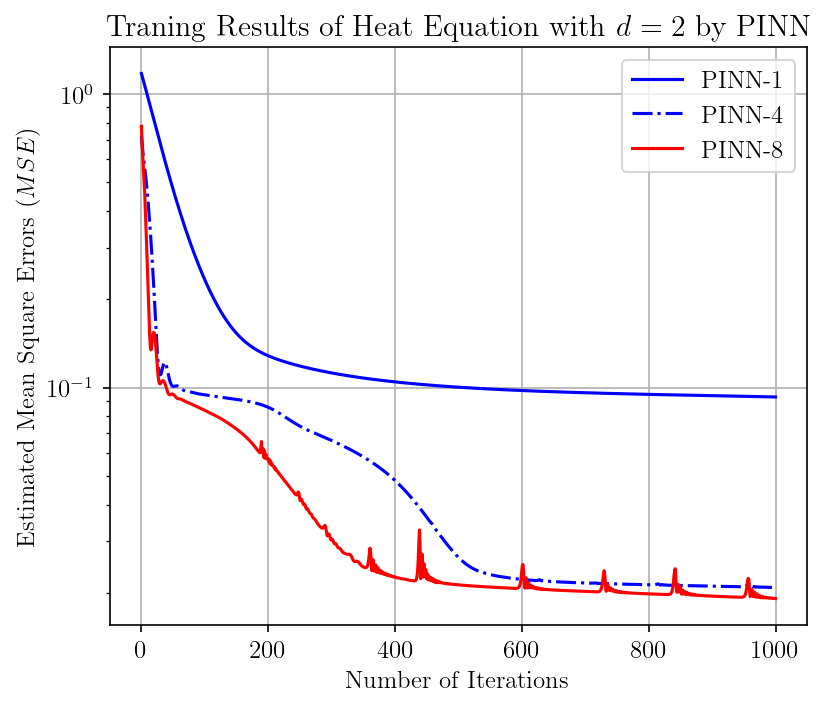

In [273]:
fig = plt.figure(figsize=(6,5), dpi=150)
colors = {1: "b", 4:"b" ,8: "r"}
linestypes = {1:"-", 4: "-.", 8: "-"}
labels = {1: "PINN-$1$", 
          4:"PINN-$4$", 
          8:"PINN-$8$"} 
# xvalues = df[df.columns[0]]

for it in layers:
    # it = df.columns[i]
    plt.semilogy(loss_dict[it], 
             label=labels[it], 
             color=colors[it],
             linestyle=linestypes[it]
            )
# plt.xlim([0,1e3])
plt.ylabel("Estimated Mean Square Errors ($MSE$)")
plt.xlabel("Number of Iterations")
plt.grid()
plt.legend()
plt.title("Traning Results of Heat Equation with $d=2$ by PINN")
plt.savefig("/Users/michaellea/001 - M.Sc_HPC/55640-Project/Seminar-2/Presentation/Slides/F0PINN.png", bbox_inches='tight')
plt.show()

In [180]:
n = 100
# l = 1.
# r = 2*l/(n+1)
# T = np.zeros([n*n, n*n])

## FDM

In [181]:
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

bc = {
    "x=-l": 1,
    "x=+l": 0.,
    "y=-l": 1.,
    "y=+l": 1.
}

B = np.zeros([n, n])
k = 0
for i in range(n):
    x = i * r
    for j in range(n):
        y = j * r
        M = np.zeros([n, n])
        M[i, j] = -4
        if i != 0: # ok i know
            M[i-1, j] = 1
        else:
            B[i, j] += -bc["y=-l"]   # b.c y = 0
        if i != n-1:
            M[i+1, j] = 1
        else:
            B[i, j] += -bc["y=+l"]   # b.c y = l
        if j != 0:
            M[i, j-1] = 1
        else:
            B[i, j] += -bc["x=-l"]   # b.c x = 0
        if j != n-1:
            M[i, j+1] = 1
        else:
            B[i, j] += -bc["x=+l"]   # b.c x = l
        #B[i, j] += -r**2 * q(x, y) * K(x, y)
        m = np.reshape(M, (1, n**2))
        T[k, :] = m
        k += 1

#
b = np.reshape(B, (n**2, 1))
start = time.time()
T = np.matmul(np.linalg.inv(T), b)
T = T.reshape([n, n])
Temperature = T
end = time.time()
computation_time["fdm"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")


computation time: 6.446



## Visualization

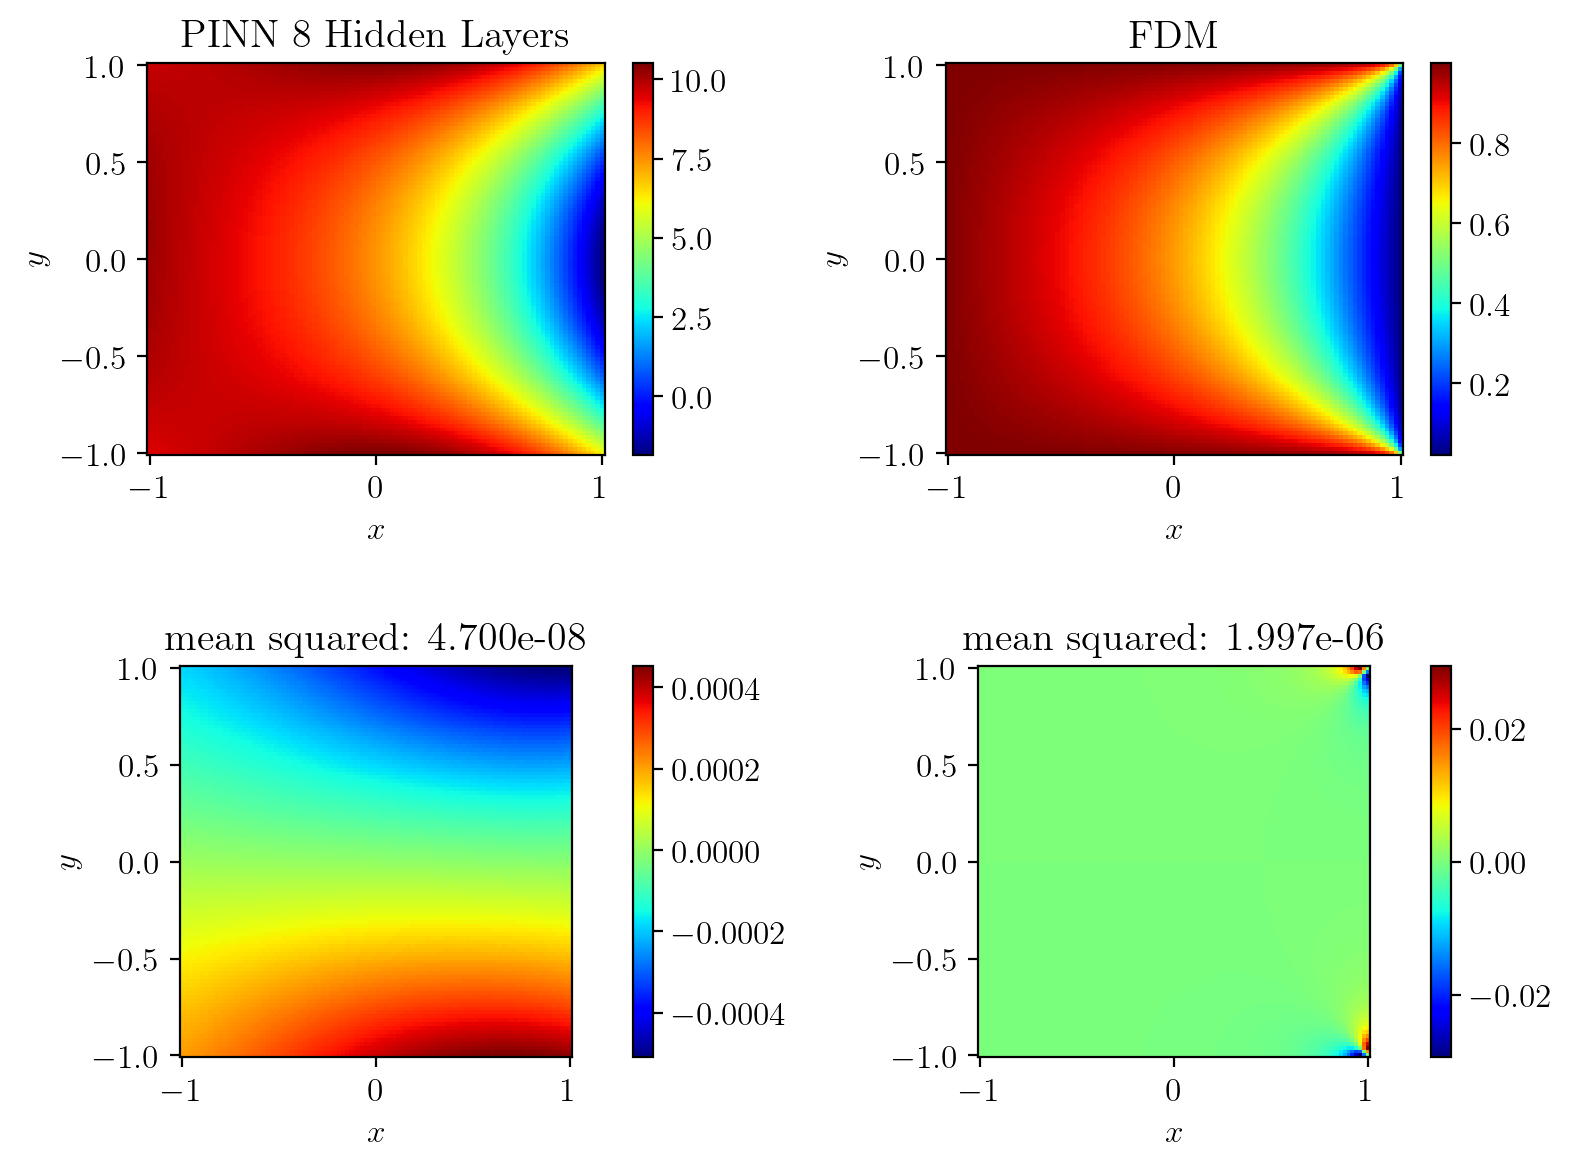

In [335]:
plt.figure("", figsize=(8, 6),dpi=200)
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

plt.subplot(221)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
plt.pcolormesh(-X0, Y0, 10.*S, cmap="jet")
plt.title("PINN 8 Hidden Layers")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()

plt.subplot(222)
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
plt.pcolormesh(x, y, T, cmap="jet")
plt.title("FDM")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()


plt.subplot(223)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
plt.pcolormesh(-X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title(f"\nmean squared: {sigma_pinn: .3e}")
plt.tight_layout()
plt.axis("square")
###
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(224)
fdm_grad = np.gradient(np.gradient(T, axis=0), axis=1)
sigma_fdm = (fdm_grad**2).mean()
plt.pcolormesh(x, y, fdm_grad, cmap="jet")
plt.colorbar()
plt.title(f"\nmean squared: {sigma_fdm: .3e}")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")

plt.savefig(f"/Users/michaellea/001 - M.Sc_HPC/55640-Project/Seminar-2/Presentation/Slides/F0PINN_COMPARE.png", bbox_inches='tight')

plt.show()

In [278]:
S

array([[0.9705118 , 0.9720444 , 0.9735262 , ..., 0.97299397, 0.96995836,
        0.96676433],
       [0.971717  , 0.97308576, 0.9744067 , ..., 0.97254395, 0.9696689 ,
        0.9666376 ],
       [0.9729831 , 0.9741851 , 0.9753419 , ..., 0.9722335 , 0.96952134,
        0.9666584 ],
       ...,
       [0.68639266, 0.65697336, 0.62816364, ..., 0.5019709 , 0.53501666,
        0.5692929 ],
       [0.66769433, 0.637882  , 0.6086921 , ..., 0.470002  , 0.5032036 ,
        0.537665  ],
       [0.64838946, 0.6181869 , 0.5886178 , ..., 0.43683037, 0.47015476,
        0.5047753 ]], dtype=float32)

In [285]:
np.savetxt("test.dat", S, fmt="%lf")

/Users/michaellea/001 - M.Sc_HPC/55640-Project/Final-Project/PIDNN/Burgers
